In [1]:
import random
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unidecode
import numpy as np
import accelerate
from collections import Counter
import torch
from datasets import load_dataset, Dataset
from evaluate import load as load_metric
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline
)
from transformers import logging
logging.set_verbosity_error()
nltk.download('stopwords') #import stopwords
nltk.download('punkt_tab') #import punkt_tab
nltk.download('wordnet') #import wordnet
random.seed(75008) #fixed random seed based on class number and group number

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shrek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding='max_length',
        max_length=128
    )

In [3]:
# Set the path to the file you'd like to load
file_path = "socialmedia-disaster-tweets-DFE.csv"

# Load the latest version of file from kaggle
DisasterTweetsDF = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "szelee/disasters-on-social-media",
  file_path,
  pandas_kwargs={"usecols": ['_unit_id','text','choose_one']}
)


In [4]:
DisasterTweetsDF.describe(include='all') #check completion and uniqueness of dataset

,_unit_id,choose_one,text
count,1.087600e+04,10876,10876
unique,NaN,3,10678
top,NaN,Not Relevant,11-Year-Old Boy Charged With Manslaughter of T...
freq,NaN,6187,13
mean,7.782503e+08,NaN,NaN
std,3.200574e+03,NaN,NaN
min,7.782438e+08,NaN,NaN
25%,7.782475e+08,NaN,NaN
50%,7.782503e+08,NaN,NaN
75%,7.782530e+08,NaN,NaN


In [5]:
print(DisasterTweetsDF['choose_one'].unique()) #expected binary classification in choose_one, investigate discrepancy

['Relevant' 'Not Relevant' "Can't Decide"]


In [6]:
DisasterTweetsDF = DisasterTweetsDF[DisasterTweetsDF.choose_one != "Can't Decide"] #remove unclassified records they will not be useful for training or testing
DisasterTweetsDF = DisasterTweetsDF.reset_index(drop=True) #reset index to prevent issues

In [7]:
stop_words = set(stopwords.words('english')) #define stopwords set
stop_words.add('http') #add http to stopwords
stop_words.add('https') #add https to stopwords
stop_words.add('www') #add www to stopwords
stemmer=PorterStemmer() #initialize stemmer
lemmatizer=WordNetLemmatizer() #initialize lemmatizer
DisasterTweetsDF['clean_list']='' #create column for cleansed text
for i in DisasterTweetsDF.index: #iterate across all records in dataframe
    word_tokens = DisasterTweetsDF.iloc[i,2].strip()
    word_tokens = word_tokens.replace("å«", "'") # Step to correct for corruptec characters due to encoding errors
    word_tokens = word_tokens.replace("amp;amp;", "amp;") # Step to correct for corruptec characters due to encoding errors
    word_tokens = word_tokens.replace("&amp;", "&") # Step to correct for corruptec characters due to encoding errors
    word_tokens = word_tokenize(word_tokens)#parse text into tokens
    clean_tokens = [] #intialize variable to hold cleansed text
    for word in word_tokens: #iterate across all word tokens
        word = word.replace("‰Û_", " ") # Step to correct for corruptec characters due to encoding errors, this is an ellipsis, not useful character
        word = word.replace("rÌ_", "ru") # Step to correct for corruptec characters due to encoding errors
        word = word.replace("pÌ_", "po") # Step to correct for corruptec characters due to encoding errors
        word = word.replace("vÌ_", "vi") # Step to correct for corruptec characters due to encoding errors
        word = word.replace("‰Û\x9d", ' ') # Step to correct for corruptec characters due to encoding errors, this is double right end qoute, not useful character
        word = word.replace("å_", ' ') # Step to correct for corruptec characters due to encoding errors, this is broken bar, not useful character
        word = word.replace("\x81_", "z") # Step to correct for corruptec characters due to encoding errors
        word = word.encode('Windows-1252') # Step to correct for corrupted characters due to encoding errors
        word = word.decode('mac-roman').encode('Windows-1252', 'replace') # Step to correct for corrupted characters due to encoding errors
        word = word.decode('utf-8') # Step to correct for corrupted characters due to encoding errors
        word = unidecode.unidecode(word,'utf-8') #remove accented characters
        word = word.lower() #set all characters to lowercase
        word = word.strip() #remove any leading/trailing whitespace
        word = re.sub('//t.co/.*', '', word) #remove any word token that is a twitter shortened url
        word = word.translate(str.maketrans(string.digits,len(string.digits)*' ')) #replace all digits with whitespace
        word = word.translate(str.maketrans(string.punctuation,len(string.punctuation)*' ')) #replace all punctuation with whitespace
        word_token = word_tokenize(word) #retokenize word based on new whitespaces
        word_token = [word for word in word_token if not word in stop_words] #keep only non-stopwords
        for word in word_token:#iterate across all word_token sub tokens
            w1 = stemmer.stem(word) #stem sub tokens
            w2 = lemmatizer.lemmatize(word)#lemmatize sub tokens
            if not word in stop_words and len(word)>2: #check if stemmed/lemmatized sub token is a stop word and of material length
                clean_tokens = clean_tokens+[w2] #append non stop words to list of clean tokens
    DisasterTweetsDF.iat[i,3] = clean_tokens #join all cleaned tokens into new clean_text column
DisasterTweetsDF['clean_text']=DisasterTweetsDF.clean_list.apply(' '.join)

In [8]:
DisasterTweetsDF['target'] = np.where(DisasterTweetsDF['choose_one'] == 'Relevant', 1, 0)
DisasterTweetsDS = Dataset.from_pandas(DisasterTweetsDF)
encoded_DisasterTweetsDS = DisasterTweetsDS.map(tokenize_function, batched=True)
encoded_DisasterTweetsDF = encoded_DisasterTweetsDS.to_pandas()
X=encoded_DisasterTweetsDF[['_unit_id','clean_text','clean_list','target','input_ids','token_type_ids','attention_mask']]
Y=encoded_DisasterTweetsDF[['target']]
train, test = train_test_split(X, test_size=0.2, random_state=75008, stratify=Y) #parse and stratify predictors and targets into training and test datasets
train = train.reset_index(drop=True) #reset index to prevent issues
test = test.reset_index(drop=True) #reset index to prevent issues

Map:   0%|          | 0/10860 [00:00<?, ? examples/s]

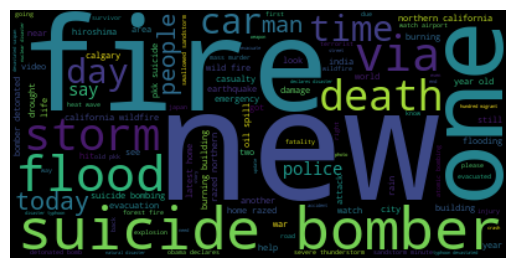

In [9]:
Total_tokens = ''
comment_words = ''

for i in range(len(train)):
    if train.iloc[i,3] == 1: 
        l2 = len(train.iloc[i,2])
        for j in range(l2):
            Total_tokens = Total_tokens+' '+train.iloc[i,2][j]
wordcloud = WordCloud().generate(Total_tokens)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

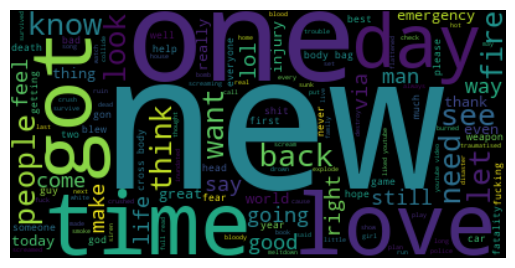

In [10]:
Total_tokens = ''
comment_words = ''

for i in range(len(train)):
    if train.iloc[i,3] == 0: 
        l2 = len(train.iloc[i,2])
        for j in range(l2):
            Total_tokens = Total_tokens+' '+train.iloc[i,2][j]
wordcloud = WordCloud().generate(Total_tokens)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
train_dataset = Dataset.from_pandas(train[['clean_text','target','input_ids','token_type_ids','attention_mask']].rename(columns = {'clean_text':'text','target':'label'}))
val_dataset = Dataset.from_pandas(test[['clean_text','target','input_ids','token_type_ids','attention_mask']].rename(columns = {'clean_text':'text','target':'label'}))

# id_to_label = {0: "NEGATIVE", 1: "POSITIVE"}
# label_to_id = {"NEGATIVE": 0, "POSITIVE": 1}

# model = AutoModelForSequenceClassification.from_pretrained(
#     "distilbert/distilbert-base-uncased", num_labels=2, id2label=id_to_label, label2id=label_to_id
# )

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.to('cpu')

precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    prec = precision_metric.compute(predictions=preds, references=labels)["precision"]
    rec = recall_metric.compute(predictions=preds, references=labels)["recall"]
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels)["f1"]
    return {"precision": prec, "recall": rec, "accuracy": acc, "f1": f1}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

{'loss': 0.5075, 'grad_norm': 3.733088731765747, 'learning_rate': 4.846531614487416e-05, 'epoch': 0.09208103130755065}
{'loss': 0.4718, 'grad_norm': 14.029726028442383, 'learning_rate': 4.6930632289748316e-05, 'epoch': 0.1841620626151013}
{'loss': 0.5112, 'grad_norm': 4.410490989685059, 'learning_rate': 4.539594843462247e-05, 'epoch': 0.27624309392265195}
{'loss': 0.4419, 'grad_norm': 15.096302032470703, 'learning_rate': 4.386126457949662e-05, 'epoch': 0.3683241252302026}
{'loss': 0.4568, 'grad_norm': 6.272260665893555, 'learning_rate': 4.232658072437078e-05, 'epoch': 0.4604051565377532}
{'loss': 0.428, 'grad_norm': 20.18685531616211, 'learning_rate': 4.079189686924494e-05, 'epoch': 0.5524861878453039}
{'loss': 0.47, 'grad_norm': 4.39852237701416, 'learning_rate': 3.9257213014119094e-05, 'epoch': 0.6445672191528545}
{'loss': 0.4745, 'grad_norm': 18.802745819091797, 'learning_rate': 3.772252915899325e-05, 'epoch': 0.7366482504604052}
{'loss': 0.4214, 'grad_norm': 1.891221284866333, 'lea

TrainOutput(global_step=3258, training_loss=0.35680410597059464, metrics={'train_runtime': 4255.8702, 'train_samples_per_second': 6.124, 'train_steps_per_second': 0.766, 'train_loss': 0.35680410597059464, 'epoch': 3.0})